In [1]:
import pandas as pd 
import numpy as np 
import lightgbm as lgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/model_input.csv')

 Log-Transform Target Variable

In [2]:
# Remove rows where total_charges <= 0
df = df[df['total_charges'] > 0].copy()

# Log-transform the target
df['log_total_charges'] = np.log1p(df['total_charges'])  

 Define Features and Target

In [23]:
feature_cols = [col for col in df.columns if col not in ['total_charges', 'log_total_charges']]  # adjust if needed
X = df[feature_cols]
y = df['log_total_charges']

Train/Test Split

In [24]:
# Split features and target 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train LightGBM Model

In [25]:
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 1873243, number of used features: 9
[LightGBM] [Info] Start training from score 10.142437


LGBMRegressor(random_state=42)

Predict & Inverse Log Transform

In [26]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log) # back to original dollar scale
y_actual = np.expm1(y_test)

Evaluate Model Performance

In [27]:
mae = mean_absolute_error(y_actual, y_pred)
rmse = mean_squared_error(y_actual, y_pred, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 14806.759200899269
RMSE: 39717.87278655571


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Create Residuals

In [28]:
residuals_df = pd.DataFrame({
    'actual': y_actual,
    'predicted': y_pred
})
residuals_df['error'] = residuals_df['actual'] - residuals_df['predicted']
residuals_df['abs_error'] = residuals_df['error'].abs()

 Save Residual Sample

In [ ]:
sample_residuals = residuals_df.sample(10000, random_state=42)
# sample_residuals.to_csv('../data/sample_residuals_lgbm_10k.csv')

****

In [30]:
# Sample residuals
residuals_df = pd.read_csv('../data/sample_residuals_lgbm_10k.csv', index_col=0)
# Original feautres
model_input_df = pd.read_csv('../data/model_input.csv')

Join on Index to Get All Original Features

In [31]:
# Join on index to get all original features for each residual
merged_df = model_input_df.loc[residuals_df.index].copy()

# Add predictions and errors back in
merged_df["actual"] = residuals_df["actual"]
merged_df["predicted"] = residuals_df["predicted"]
merged_df["error"] = residuals_df["error"]
merged_df["abs_error"] = residuals_df["abs_error"]

In [32]:
merged_df.describe()
merged_df["abs_error"].describe()
merged_df["diagnosis_encoded"].value_counts(normalize=True).head(10)

diagnosis_encoded
137    0.0998
241    0.0478
167    0.0251
150    0.0229
12     0.0228
221    0.0214
67     0.0207
238    0.0206
56     0.0183
177    0.0177
Name: proportion, dtype: float64

Analyze Top 1000 Worst Residuals

In [33]:
top1000 = merged_df.sort_values(by='abs_error', ascending=False).head(1000)
top1000["diagnosis_encoded"].value_counts(normalize=True).head(10)

diagnosis_encoded
241    0.104
69     0.045
8      0.036
7      0.035
137    0.033
63     0.033
56     0.031
249    0.031
112    0.028
167    0.025
Name: proportion, dtype: float64

Top Diagnoses in Full Dataset

In [34]:
model_input_df["diagnosis_encoded"].value_counts(normalize=True).head(10)

diagnosis_encoded
137    0.095809
241    0.047380
167    0.028714
150    0.023119
12     0.021543
67     0.021195
221    0.019503
177    0.018355
238    0.017987
56     0.017978
Name: proportion, dtype: float64

In [35]:
# Load diagnosis map and merge the labels
diagnosis_map = pd.read_csv('../data/diagnosis_mapping.csv')

merged_df = merged_df.merge(diagnosis_map, on='diagnosis_encoded', how='left')
model_input_df = model_input_df.merge(diagnosis_map, on='diagnosis_encoded', how='left')

In [36]:
top_1000 = merged_df.sort_values(by='abs_error', ascending=False).head(1000)

# Worst error diagnoses
top_1000['ccs_diagnosis_description'].value_counts(normalize=True).head(10)

ccs_diagnosis_description
Septicemia (except in labor)                                       0.104
Coronary atherosclerosis and other heart disease                   0.045
Acute myocardial infarction                                        0.036
Acute cerebrovascular disease                                      0.035
Liveborn                                                           0.033
Complication of device; implant or graft                           0.033
Cardiac dysrhythmias                                               0.031
Spondylosis; intervertebral disc disorders; other back problems    0.031
Heart valve disorders                                              0.028
Osteoarthritis                                                     0.025
Name: proportion, dtype: float64

**Septicemia:** Overrepresented in Worst Errors
- It makes up 11.3% of the top 1000 worst predictions

- But only **4.7%** of the total dataset
- More than **2×** its expected frequency
- This suggests the model is consistently underperforming for this diagnosis.

**Liveborn:** Underrepresented in Worst Errors
- Makes up only **2.9%** of top 1000 worst predictions

- But nearly 9.6% of total dataset

- 1/3 of its expected frequency

In [37]:
# Full dataset
model_input_df['ccs_diagnosis_description'].value_counts(normalize=True).head(10)

ccs_diagnosis_description
Liveborn                                                                          0.095809
Septicemia (except in labor)                                                      0.047380
Osteoarthritis                                                                    0.028714
Mood disorders                                                                    0.023119
Alcohol-related disorders                                                         0.021543
Congestive heart failure; nonhypertensive                                         0.021195
Pneumonia (except that caused by tuberculosis or sexually transmitted disease)    0.019503
Other complications of birth; puerperium affecting management of mother           0.018355
Schizophrenia and other psychotic disorders                                       0.017987
Cardiac dysrhythmias                                                              0.017978
Name: proportion, dtype: float64

Generate and analyze SHAP values to explain why the model:
- Overpredicts or underpredicts certain diagnoses (like Septicemia),
- Performs well on others (like Liveborn).




Load the SHAP explainer to analyze feature importance per prediction.

In [38]:
# Create the SHAP explainer using model 
explainer = shap.Explainer(model)

# Apply to the test set only (used for model evaluation)
shap_values = explainer(X_test)

Add Diagnosis Labels to X_test

In [39]:
# Add diagnosis code to the test set for filtering 
X_test_with_diag = X_test.copy()
X_test_with_diag['diagnosis_encoded'] = df.loc[X_test.index, 'diagnosis_encoded']

Filter for Specific Cases

In [40]:
# Septicemia (code 241)
septicemia_cases = X_test_with_diag[X_test_with_diag['diagnosis_encoded'] == 241]

# Liveborn (code 137)
liveborn_cases = X_test_with_diag[X_test_with_diag['diagnosis_encoded'] == 137]

Plot SHAP Summary for Each Diagnosis

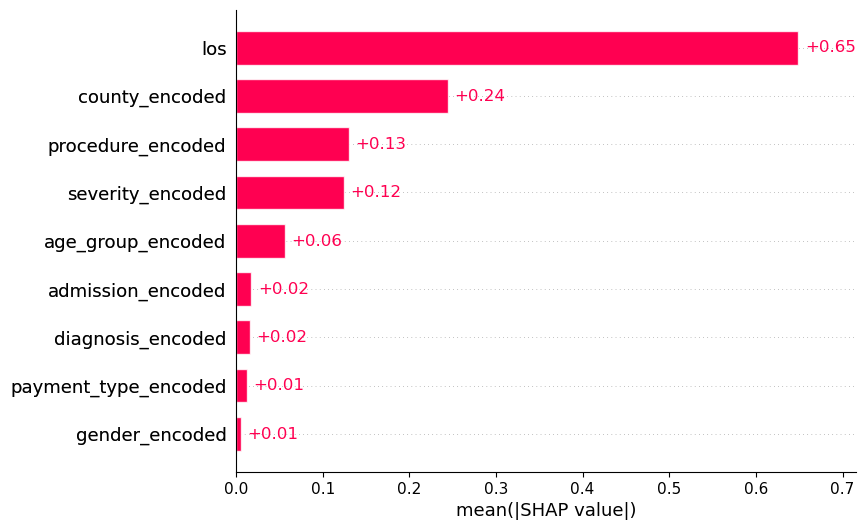

In [42]:
# Convert index to position
septicemia_pos = X_test.index.get_indexer(septicemia_cases.index)
liveborn_pos = X_test.index.get_indexer(liveborn_cases.index)

# Plot SHAP bar charts
shap.plots.bar(shap_values[septicemia_pos], max_display=10)


## Septicemia – High Error Group

Top features influencing poor predictions:

- **los** (+0.65): Variable length of stay increases cost uncertainty.
- **county_encoded** (+0.24): Regional charge differences.
- **procedure_encoded** (+0.13): Varying treatment complexity.
- **severity_encoded** (+0.12): Wide range of illness severity.
- **age_group_encoded** (+0.06): Age impacts treatment needs.

Insight: Septicemia cases are diverse and unpredictable — consider modeling this subgroup separately or adding richer features.

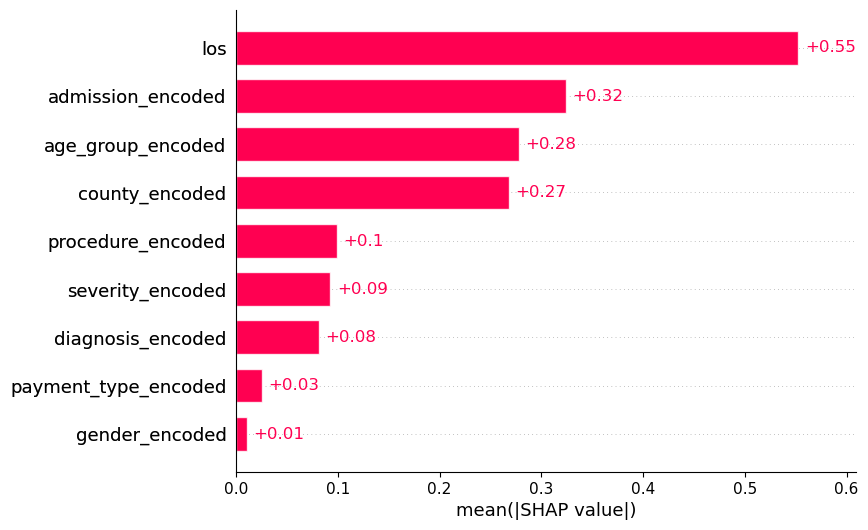

In [43]:
shap.plots.bar(shap_values[liveborn_pos], max_display=10)

## Liveborn – Low Error Group

Top features in accurate predictions:

- **los** (+0.55): Standardized hospital stays.
- **admission_encoded** (+0.32): Predictable admission types.
- **age_group_encoded** (+0.28): Consistent age ranges.
- **county_encoded** (+0.27): Regional impact still present.
- **procedure_encoded** (+0.10): Similar care pathways.

Insight: Liveborn charges are easier to predict due to uniform clinical processes.

 Quantify the Model’s Error for Septicemia and Liveborn

In [51]:
# Add back predictions to thee test set
X_test_with_diag['y_actual'] = y_actual
X_test_with_diag['y_pred'] = y_pred
X_test_with_diag['abs_error'] = np.abs(y_actual - y_pred)

# Group-wise MAE
mae_septicemia = X_test_with_diag[X_test_with_diag['diagnosis_encoded'] == 241]['abs_error'].mean()
mae_liveborn = X_test_with_diag[X_test_with_diag['diagnosis_encoded'] == 137]['abs_error'].mean()

print("Septicemia MAE:", mae_septicemia)
print("Liveborn MAE:", mae_liveborn)

Septicemia MAE: 22981.64217069653
Liveborn MAE: 7063.676464687455


### Diagnosis-Specific Error Comparison

- **Septicemia (241):** MAE = $22,981
- **Liveborn (137):** MAE = $7,063

This confirms that Septicemia cases have more prediction variability, likely due to differences in hospital LOS, procedures, and regional cost variation.

Top 5 Highest-Error Septicemia Cases 

In [57]:
y_actual_series = pd.Series(y_actual, index=X_test.index)
y_pred_series = pd.Series(y_pred, index=X_test.index)

X_test_with_diag[X_test_with_diag['diagnosis_encoded'] == 241]\
    .assign(actual=y_actual_series, predicted=y_pred_series)\
    .assign(abs_error=lambda d: np.abs(d.actual - d.predicted))\
    .sort_values(by='abs_error', ascending=False)\
    .head(5)

,gender_encoded,age_group_encoded,severity_encoded,admission_encoded,payment_type_encoded,diagnosis_encoded,procedure_encoded,county_encoded,los,y_actual,y_pred,abs_error,actual,predicted
2105275,0,1,4,2,0,241,72,26,44,1916673.00,481231.334587,1.435442e+06,1916673.00,481231.334587
2099161,1,3,4,3,2,241,34,26,99,2153292.06,805423.622663,1.347868e+06,2153292.06,805423.622663
2103675,0,3,2,3,2,241,66,26,88,1632540.26,316277.131390,1.316263e+06,1632540.26,316277.131390
2105407,1,2,4,2,1,241,72,26,63,1773109.00,615139.932956,1.157969e+06,1773109.00,615139.932956
2089201,0,4,1,3,2,241,150,26,33,1140475.95,167432.670023,9.730433e+05,1140475.95,167432.670023


In [ ]:
X_test_with_diag[X_test_with_diag['diagnosis_encoded'] == 137]\
    .assign(actual=y_actual_series, predicted=y_pred_series)\
    .assign(abs_error=lambda d: np.abs(d.actual - d.predicted))\
    .sort_values(by='abs_error', ascending=False)\
    .head(5)

,gender_encoded,age_group_encoded,severity_encoded,admission_encoded,payment_type_encoded,diagnosis_encoded,procedure_encoded,county_encoded,los,y_actual,y_pred,abs_error,actual,predicted
1077903,1,0,4,0,1,137,181,55,119,2450770.69,9.877961e+05,1.462975e+06,2450770.69,9.877961e+05
1109533,0,0,3,0,3,137,162,26,50,1772102.98,5.356331e+05,1.236470e+06,1772102.98,5.356331e+05
1109200,1,0,4,0,1,137,152,55,112,2223260.56,1.003486e+06,1.219775e+06,2223260.56,1.003486e+06
1081074,1,0,3,0,0,137,184,26,115,1766369.79,6.819648e+05,1.084405e+06,1766369.79,6.819648e+05
1195516,1,0,4,0,1,137,201,55,104,2034401.61,9.555150e+05,1.078887e+06,2034401.61,9.555150e+05


### Analyze MAE by LOS Bucket
Investigate how the model's error varies across different lengths of stay.

In [60]:
# Build DataFrame with predictions and los 
loss_df = X_test.copy()
loss_df["actual"] = y_actual
loss_df["predicted"] = y_pred
loss_df["abs_error"] = np.abs(loss_df["actual"] - loss_df["predicted"])
loss_df["los"] = df.loc[X_test.index, "los"]


In [61]:
# Create los bins
los_bins = pd.cut(loss_df["los"], bins=[0, 3, 7, 14, 30, 60, 90, 365], right=False)
loss_df["los_bin"] = los_bins

# Calculate MAE per bin
mae_by_los = loss_df.groupby("los_bin")["abs_error"].mean()

/var/folders/6z/l9wv3crd4n5bzgcrdd7vxq8m0000gn/T/ipykernel_19307/747516376.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_by_los = loss_df.groupby("los_bin")["abs_error"].mean()


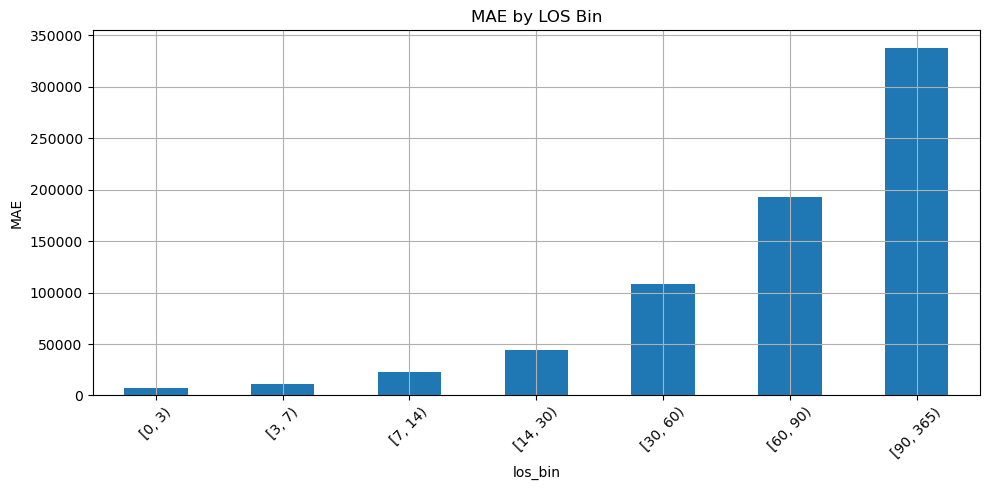

In [62]:
# Plot
mae_by_los.plot(kind='bar', figsize=(10,5), title="MAE by LOS Bin", ylabel="MAE")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation: MAE by Length of Stay (LOS)

This chart shows how prediction error (MAE) varies across different **Length of Stay (LOS)** bins.

#### Observations:
- **Short stays (0–7 days)**  
  → Low MAE (under $15,000) — the model performs well on routine, short hospitalizations.

- **Medium stays (14–30 days)**  
  → MAE increases (~$45,000), reflecting more variation in care and charges.

- **Long stays (30+ days)**  
  → MAE rises steeply:
  - 30–60 days: MAE exceeds $100,000  
  - 60–90 days: ~ $190,000  
  - 90–365 days: MAE peaks over **$340,000**

#### Interpretation:
- Model accuracy **declines significantly** as LOS increases.
- Long-stay patients likely involve more complex care, billing variability, and outliers.
- LOS is a **strong driver of model error**.